# <center>White House Posts' Affect on Stock Market</center>

### Author: Richard Doan

I: Implement an exploratory technique:

 

If your data has some structure, for example it is in categories or has metadata (such as review ratings) attached, you may want to implement a supervised machine learning technique to identify the most distinctive words or features for each of your categories.

If you have shorter, more focused documents, or you only have a few documents (1-5), you might want to do vector space exploration, such as MDS or a dendrogram using a distance measure, or a clustering technique.

If you have longer, more complex documents and you have many of them (10 or more), you might want to implement a topic modeling algorithm.

Or, you can focus on the word level by using word weighting, frequent words, or word distinctiveness scores (such as chi-squared).

If you have specific words – or groups of words – you want to explore, you might choose to implement a word embeddings model.

 

II: Discuss the results. Did you find any themes or clusters that were obvious? Were there any themes or clusters that were not obvious? Were there any that did not make sense? Did this exercise generate any hypotheses about your corpus, or themes you might want to explore further? Why or why not?



### Part 1
- ~~Tokenize~~
- ~~Get Most Meaningful Words~~
- ~~Word embedding, cluster the most meaningful words with color~~
- Get word distinctiveness score
- ~~Logistic Regression to give likelihoods, after pca to reduce dimensionality maybe~~

### Part 2
- Interpret 

## Introduction



To run through the examples interactively, please run the code in the **Appendix** at the bottom of this notebook after reading this.

## Data Schema and Collection Method

Because we are looking into how White House announcements affect the stock market, our dataset will be composed of raw White House blog posts and a few index fund prices. Major index fund prices are used as indicators as to how strong a country's economy is, which is what inspired the use of them in our analysis. The index funds we will be focusing are Dow Jones, S&P 500, and NASDAQ.

For each blog post, we get the closing prices of our three index funds on the day that blog post is posted. We then grab the price of the same funds, but for the next day. From there we take the price of the index funds on the next day, subtract that from the current day to get the price change, and then average over the three index fund price changes. This gave us numeric data to work with. We decided to average the fund prices instead of taking the max or the median. 

We noticed that absolute price changes may not give us as much information as relative price changes, so we repeated the above, but in addition to the subtraction, we divided the change in price with the price of the blog post date and then averaged. Labels were then generated from the average proportion change of the three index fund prices. If the proportion change was positive, then we labeled the corresponding blog post as 1, otherwise, we labeled the blog post as -1. 

There were a few nuances that we had to overcome, which have added biases to our data collection methods. We weren't sure which blog posts would correspond to market motions, so we took every post that was on the White House blog page. This meant that there are cases where there are many posts to one day, so there are many posts to one closing price. To overcome this problem, we concatenated the blog posts that occur on the same day in this analysis.

Below is the resulting dataframe from our collection method.

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/rykard95/wh_stocks/master/data/dataset.csv', dtype=DATATYPES).dropna()
dataset = join_blog_posts_on_date(df)
dataset['Title'] = dataset['Title'].apply(lambda title: title +' ')
dataset['Body'] = dataset['Body'].apply(lambda body: body + ' ')
dataset[:3]

,Date,Body,Title,Dow Jones Delta,Dow Jones Proportion,Nasdaq Delta,Nasdaq Proportion,S&P 500 Delta,S&P 500 Proportion,Mean Delta,Mean Proportion,Label
0,2017-03-06,President Donald J Trump spoke separately toda...,Readout of the Presidents Calls with Prime Min...,-29.580078,-0.001412,-15.250000,-0.002607,-6.920166,-0.002913,-17.250082,-0.002311,-1
1,2017-04-03,President Donald J Trump today welcomed Presid...,Readout of President Donald J Trumps Meeting w...,39.029297,0.001890,3.929687,0.000667,1.319824,0.000560,14.759603,0.001039,1
2,2017-03-21,President Donald J Trump will travel to Brusse...,Statement by the Press Secretary on President ...,-6.708985,-0.000325,27.810059,0.004800,4.429931,0.001890,8.510335,0.002122,1


## Word Analysis

Once we have our data scheme, I focused on the word level of our project. The hope was to gain insight as to what featurization method would be best to create a predictive model. Text analysis is trickier than numeric problems in machine learning. There are many ways to featurize unstructured text data, and the choice of featurization often introduces latent biases into machine learning models. 

Below I grouped the blog posts according to their label, concatenated the body of the blog posts together, and then tokenized (removing stop words) the larger text. I used the difference of proportions method to see if there were any major usage differences of certain words between the different labels. It seems as though the largest difference seen across the labels was when 'spicer' was mentioned, and the usage difference was only 0.002 more in the negative label.

I then repeated the same process, but with the titles of the blog posts instead. The results of the difference of proportions method seem more promising for the titles than those of the bodies. Here we see the largest difference of 0.014 more in the negative label. The word associated with this difference was 'meeting'. From these results, it seems as though the title might give us more information about stock market motions. A reason for this might be that because titles need to be concise, so each word must carry more distinctive information about the theme. In which case, more distinctive themes could correlate in some way to stock market motions.

In [9]:
body_df = generate_word_df(dataset, text='Body')
body_df[:10]

The total number of positive words is 141560
The total number of negative words is 140548


,Word,Positive,Negative,Positive Proportion,Negative Proportion,diff,diff proportion,abs diff proportion
3,spicer,1044,1252,0.007,0.009,-208,-0.002,0.002
0,president,2628,2501,0.019,0.018,127,0.001,0.001
70,general,267,176,0.002,0.001,91,0.001,0.001
110,eo,193,34,0.001,0.000,159,0.001,0.001
103,actions,201,78,0.001,0.001,123,0.001,0.001
101,regulations,202,88,0.001,0.001,114,0.001,0.001
99,plan,205,287,0.001,0.002,-82,-0.001,0.001
96,women,209,90,0.001,0.001,119,0.001,0.001
88,process,224,297,0.002,0.002,-73,-0.001,0.001
73,applause,259,180,0.002,0.001,79,0.001,0.001


In [10]:
title_df = generate_word_df(dataset, 'Title')
title_df[:15]

The total number of positive words is 1509
The total number of negative words is 1340


,Word,Positive,Negative,Positive Proportion,Negative Proportion,diff,diff proportion,abs diff proportion
28,meeting,11,29,0.007,0.022,-18,-0.014,0.014
60,march,6,21,0.004,0.016,-15,-0.012,0.012
12,call,24,7,0.016,0.005,17,0.011,0.011
0,president,145,116,0.096,0.087,29,0.010,0.010
14,house,21,32,0.014,0.024,-11,-0.010,0.010
171,proclaims,2,12,0.001,0.009,-10,-0.008,0.008
4,donald,41,47,0.027,0.035,-6,-0.008,0.008
5,j,41,47,0.027,0.035,-6,-0.008,0.008
9,trumps,26,12,0.017,0.009,14,0.008,0.008
10,order,25,12,0.017,0.009,13,0.008,0.008


## Most Distinctive Words

Below is a different analysis of the most distinctive words. Instead of the difference of proportions, I used a chi-squared test to determine what words were statistically different in frequency across our two labels. I first do this analysis using the blog post body, and then I repeat the process using the blog post titles.

When analyzing words in the body, there doesn't seem to be any overlap between the words found to be significantly different using the difference of proportions and the chi-squared test. The same holds for words in the title. 

**What does this mean??**

In [29]:
vectorizer = CountVectorizer(stop_words='english')
data = vectorizer.fit_transform(dataset['Body'])

indexes = np.argsort(chi2(data, dataset['Label'])[0])[:100]
top_body_words = np.array(vectorizer.get_feature_names())[indexes]
print("These are the words given by chi-squared...")
print()
print(top_body_words)
print()
print()
print("These are the words given by the difference of proportions...")
print()
print(np.array(body_df['Word'][:100].tolist()))
print()
print()
print("This is this the list of words from the difference of proportion list that are in the chi-squared list...")
print()
print(np.array([word in top_body_words for word in body_df['Word'][:100].tolist()]))

These are the words given by chi-squared...

['publish' 'portion' 'proper' 'rightmr' 'soldiers' 'informed' 'honestly'
 'area' 'dollars' 'free' 'addition' 'having' 'sell' 'readout' 'parties'
 'range' 'kids' 'learned' 'change' 'mike' 'wrote' 'subsequent'
 'generations' 'break' 'challenge' 'marketplace' 'lack' 'litigation' 'gave'
 'policy' 'rights' 'peaceful' 'hearings' 'largely' 'russians' 'function'
 'directing' 'uniform' 'sides' 'took' 'nominee' 'broken' 'list' 'pence'
 'right' 'direct' 'problems' 'aspect' 'developing' 'chemical'
 'professional' 'forgotten' 'rolling' 'private' 'hope' 'friend' 'allies'
 'ending' 'empower' 'door' 'creators' 'additionally' 'troops' 'alex'
 'keeps' 'reset' 'negotiations' 'hoping' 'launched' 'german' 'extremely'
 'taxpayer' 'presented' 'talks' 'district' 'arent' 'specifically'
 'extraordinary' 'car' 'named' 'podium' 'prepare' 'revenues' 'grant'
 'component' 'service' 'course' 'international' 'yeah' 'simple' 'bless'
 'particular' 'reinvest' 'meetingsq' 'impl

In [30]:
vectorizer = CountVectorizer(stop_words='english')
data = vectorizer.fit_transform(dataset['Title'])

indexes = np.argsort(chi2(data, dataset['Label'])[0])[:100]
top_title_words = np.array(vectorizer.get_feature_names())[indexes]
print("These are the words given by chi-squared...")
print()
print(top_title_words)
print()
print()
print("These are the words given by the difference of proportions...")
print()
print(np.array(title_df['Word'][:100].tolist()))
print()
print()
print("This is this the list of words from the difference of proportion list that are in the chi-squared list...")
print()
print(np.array([word in top_title_words for word in title_df['Word'][:100].tolist()]))

These are the words given by chi-squared...

['statement' 'discussion' 'guests' 'travel' 'discuss' 'committee' 'majesty'
 'insurance' 'dan' 'treasury' 'initiative' 'alsisi' 'promote' 'make'
 'federalism' 'sanders' 'angela' 'investment' 'bipartisan' 'excellence'
 'bin' 'second' 'support' 'prolife' 'photos' 'regulations' 'contracting'
 'empowerment' 'karen' 'charter' 'authority' 'attorney' 'florida'
 'upcoming' 'medal' 'acting' 'officials' 'comprehensive' 'reopening'
 'reorganizing' 'abuse' 'gerald' 'winter' 'gala' 'new' 'cabinet'
 'recipients' 'administrator' 'parentteacher' 'revocation' 'right' 'ford'
 'african' 'verma' 'minister' 'address' 'delivers' 'japan' 'establishing'
 'orders' 'route' 'week' 'en' 'message' 'care' 'al' 'womens' 'general'
 'department' 'chancellor' 'jordan' 'alabadi' 'legislative' 'memorandum'
 'weekly' 'nominate' 'intent' 'respect' 'gorsuch' 'visit' 'supreme'
 'budgetary' 'entitled' 'impact' 'congress' 'analysis' 'announces'
 'secretary' 'press' 'independence' 'c

## Clustering 

After noticing that inconclusiveness of the above methods, we approached our problem from a clustering standpoint to see why it was so difficult finding distinct words. We used the cosine distance metric to determine the similarity of two blog posts. We also used MDS, which we learned about in class, and also T-SNE, which we learned about after doing more research into high-dimensional visualizations. 

From these two plots, for both analyzing only the body or only the title, we can see that our data doesn't seem to follow any particular pattern. What this means is that our method of creating a vector space of documents does not lend itself to discriminating between our two labels very well.


**Talk about the clustering attempt to gain insight about this data visually given the features**

**Make this look nice**

In [52]:
cos_dist = 1 - cosine_similarity(data)

mds = MDS(n_components=2, dissimilarity="precomputed")

pos = mds.fit_transform(cos_dist)# shape (n_components, n_samples)
colors = [(0, 'blue', 'red')[label] for label in dataset['Label']]
xs, ys = pos[:, 0], pos[:, 1]

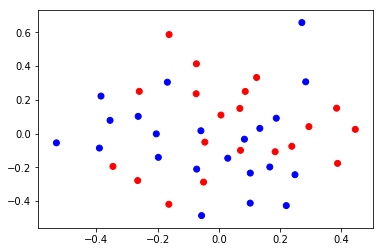

In [53]:
plt.scatter(xs, ys, c=colors)
plt.show()

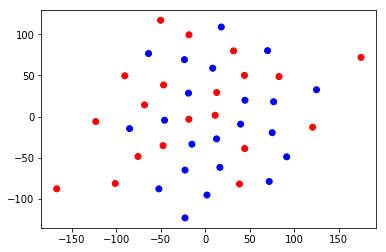

In [65]:
tsne = TSNE(n_components=2)
pos = tsne.fit_transform(data.toarray())
colors = [(0, 'blue', 'red')[label] for label in dataset['Label']]
xs, ys = pos[:, 0], pos[:, 1]
plt.scatter(xs, ys, c=colors)
plt.show()

## Hypothesis

From the information gathered above, it is inconclusive if there is a relationship between White House post content and stock market motion. The difference of proportions between upward trends and downward trends tells us that there may be more distinctive content in the title of the blog post rather than the bodies. The Chi Squared tests shows us what distinctive words exist in the titles. On the contrary, given our feature space, the Multidimensional Scaling plots do not show any signs of distinct clusters. **This could be due to the fact that we encode noise into our data because we are unable to get a better granualarity of timestamps.**

## Appendix: Imports, Globals, and Helper Functions

In [1]:
from re import sub
import pandas as pd
import numpy as np

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import MDS, TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_selection import chi2

from matplotlib import pyplot as plt



stopwords = set(stopwords.words('english'))

DATATYPES = {'Dow Jones Value': np.float32,
            'Dow Jones Delta': np.float32,
            'Dow Jones Proportion': np.float32,
            'Nasdaq Value': np.float32,
            'Nasdaq Delta': np.float32,
            'Nasdaq Proportion': np.float32,
            'S&P 500 Value': np.float32,
            'S&P 500 Delta': np.float32,
            'S&P 500 Proportion': np.float32 
            }

def join_blog_posts_on_date(df):
    posts = {}
    titles = {}
    for index,row in df.iterrows():
        date = row['Date']
        if date not in posts:
            posts[date] = []
            titles[date] = []
        posts[date].append(row['Body'])
        titles[date].append(row['Title'])

    posts = {date:' '.join(posts[date]) for date in posts}
    titles = {date: ' '.join(titles[date]) for date in titles}

    posts = pd.DataFrame(list(posts.items()))
    posts.columns = ['Date', 'Body']

    titles = pd.DataFrame(list(titles.items()))
    titles.columns = ['Date', 'Title']

    dj_deltas = df[['Date', 'Dow Jones Delta']].drop_duplicates()
    nd_deltas = df[['Date', 'Nasdaq Delta']].drop_duplicates()
    sp_deltas = df[['Date', 'S&P 500 Delta']].drop_duplicates()

    dj_delta_prop = (df['Dow Jones Delta'] / df['Dow Jones Value']).drop_duplicates()
    nd_delta_prop = (df['Nasdaq Delta'] / df['Nasdaq Value']).drop_duplicates()
    sp_delta_prop = (df['S&P 500 Delta'] / df['S&P 500 Value']).drop_duplicates()

    dj_deltas['Dow Jones Proportion'] = dj_delta_prop
    nd_deltas['Nasdaq Proportion'] = nd_delta_prop
    sp_deltas['S&P 500 Proportion'] = sp_delta_prop
    
    dataset = pd.merge(posts, titles, how='inner', on=['Date'])
    dataset = pd.merge(dataset, dj_deltas, how='inner', on=['Date'])
    dataset = pd.merge(dataset, nd_deltas, how='inner', on=['Date'])
    dataset = pd.merge(dataset, sp_deltas, how='inner', on=['Date'])

    dataset['Body'] = dataset['Body'].str.replace('\d+', '').str.replace('[^a-zA-Z ]', '')
    dataset['Title'] = dataset['Title'].str.replace('\d+', '').str.replace('[^a-zA-Z ]', '')
    dataset['Mean Delta'] = (dataset['Dow Jones Delta'] + dataset['Nasdaq Delta'] + dataset['S&P 500 Delta']) / 3
    dataset['Mean Proportion'] = (dataset['Dow Jones Proportion'] + 
                                  dataset['Nasdaq Proportion'] + 
                                  dataset['S&P 500 Proportion']) / 3
    dataset['Label'] = (dataset['Mean Proportion'] >= 0).apply(int)
    dataset['Label'] = 2 * dataset['Label'] - 1
    return dataset

def generate_word_df(df, text='Body'):
    grouped = df.groupby('Label')
    joined_text = grouped[text].sum()
    negative_text = joined_text[-1]
    positive_text = joined_text[1]
    
    positive_text_words = count_words(positive_text)
    negative_text_words = count_words(negative_text)
    
    positive_words = pd.DataFrame(list(positive_text_words.items()), 
                              columns=['Word', 'Positive']).sort_values(by='Positive',
                                                                     ascending=False)
    negative_words = pd.DataFrame(list(negative_text_words.items()), 
                              columns=['Word', 'Negative']).sort_values(by='Negative',
                                                                     ascending=False)
    
    word_df = pd.merge(positive_words, negative_words, how='inner', on=['Word'])

    total_positive = word_df['Positive'].sum()
    total_negative = word_df['Negative'].sum()
    word_df['Positive Proportion'] = word_df['Positive'] / total_positive
    word_df['Negative Proportion'] = word_df['Negative'] / total_negative
    word_df['diff'] = word_df['Positive'] - word_df['Negative']
    word_df['diff proportion'] = word_df['Positive Proportion'] - word_df['Negative Proportion']
    print("The total number of positive words is %d" % word_df['Positive'].sum())
    print("The total number of negative words is %d" % word_df['Negative'].sum())
    
    word_df = word_df.round({'Positive Proportion':3, 'Negative Proportion':3, 'diff proportion':3})
    word_df['abs diff proportion'] = word_df['diff proportion'].abs()
    word_df = word_df.sort_values(by='abs diff proportion', ascending=False)
    return word_df

def count_words(text):
    text = sub('[^a-zA-Z ]', '', text)
    counts = {}
    for word in text.lower().split():
        if word in stopwords:
            continue
        if word not in counts:
            counts[word] = 0
        counts[word] += 1
    return counts